In [1]:
from __future__ import print_function, division
import os
import argparse
import torch.nn as nn
from skimage import io
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader
from utils import *
from utils.KittiColormap import *
from pyntcloud import PyntCloud
import pandas as pd
from cv_bridge import CvBridge
import cv2
%matplotlib inline
import matplotlib.pyplot as plt
from datasets.data_io import get_transform, read_all_lines
from PIL import Image
import open3d as o3d

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


## Load Data from ZED dataset

In [82]:
def load_image(filename):
    return Image.open(filename).convert('RGB')

def load_disp(filename):
    data = Image.open(filename)
    data = np.array(data, dtype=np.float32) / 256.
    return data

In [83]:
datapath = "/home/chris/pl_ws/src/stereo_pl_nav/datasets/zed_dataset/"
left_img = load_image(os.path.join(datapath, "left/isec/16511058771.jpg"))
right_img = load_image(os.path.join(datapath, "right/isec/16511058771.jpg"))

(376, 672, 3)


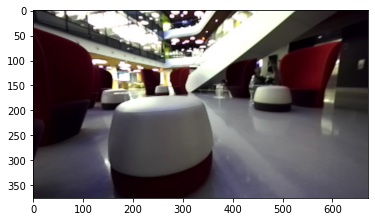

In [84]:
plt.imshow(left_img)
left_frame = np.asarray(left_img)
left_depth_rgb = left_frame[:, :, :3]
print(np.asarray(left_img).shape)

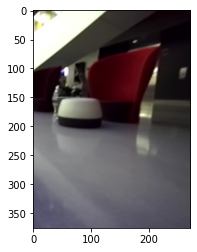

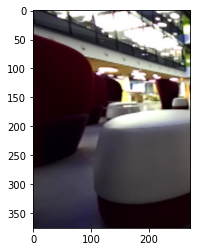

In [85]:
plt.imshow(np.array(left_img)[:,400:,:])
plt.show()

plt.imshow(np.array(right_img)[:,:-400,:])
plt.show()

In [86]:
w, h = left_img.size
crop_w, crop_h = 880, 400

left_img = np.array(left_img)
right_img = np.array(right_img)

left_img = np.transpose(left_img, (2,0,1))
right_img = np.transpose(right_img, (2,0,1))

print(left_img.shape)

left_img = np.lib.pad(left_img, ((0, 0), (0, crop_h-h), (0, crop_w-w)), mode='constant', constant_values=0)
right_img = np.lib.pad(right_img, ((0, 0), (0, crop_h-h), (0, crop_w-w)), mode='constant', constant_values=0)
print(left_img.shape)

depth_rgb = left_img[:3, :, :]
print(depth_rgb.shape)

left_img = np.transpose(left_img, (1,2,0))
right_img = np.transpose(right_img, (1,2,0))
processed = get_transform()
left_img = processed(left_img).numpy()
right_img = processed(right_img).numpy()


(3, 376, 672)
(3, 400, 880)
(3, 400, 880)


In [87]:
left_img.shape

(3, 400, 880)

In [88]:
from models.mobilestereonet.models.MSNet2D import MSNet2D
model = MSNet2D(192)
model = nn.DataParallel(model)
model.cuda()

DataParallel(
  (module): MSNet2D(
    (feature_extraction): feature_extraction(
      (firstconv): Sequential(
        (0): MobileV2_Residual(
          (conv): Sequential(
            (0): Conv2d(3, 9, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(9, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
            (3): Conv2d(9, 9, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=9, bias=False)
            (4): BatchNorm2d(9, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (5): ReLU6(inplace=True)
            (6): Conv2d(9, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
        )
        (1): ReLU(inplace=True)
        (2): MobileV2_Residual(
          (conv): Sequential(
            (0): Conv2d(32, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          

In [89]:
ckpt_path = "/home/chris/pl_ws/src/stereo_pl_nav/scripts/models/MSNet2D_SF_DS_KITTI2015.ckpt"
print("Loading model {}".format(ckpt_path))
state_dict = torch.load(ckpt_path)
model.load_state_dict(state_dict['model'])

Loading model /home/chris/pl_ws/src/stereo_pl_nav/scripts/models/MSNet2D_SF_DS_KITTI2015.ckpt


<All keys matched successfully>

In [90]:
# Camera intrinsics and extrinsics
c_u = 4.556890e+2
c_v = 1.976634e+2
f_u = 1.003556e+3
f_v = 1.003556e+3
b_x = 0.0
b_y = 0.0
baseline = 0.54

WARNING - 2022-05-12 02:56:03,337 - image - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


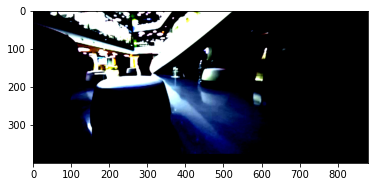

WARNING - 2022-05-12 02:56:03,407 - image - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


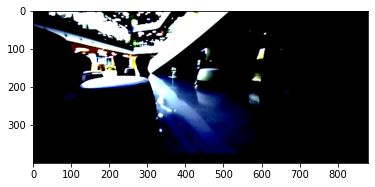

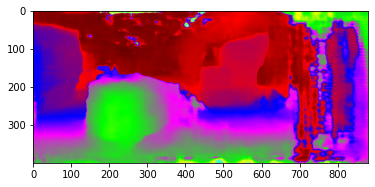

In [91]:
import matplotlib.pyplot as plt

model.eval()
plt.imshow(np.transpose(left_img, (1,2,0)))
plt.show()
plt.imshow(np.transpose(right_img, (1,2,0)))
plt.show()

sample_left = torch.Tensor(left_img)
sample_right = torch.Tensor(right_img)

sample_left = torch.unsqueeze(sample_left, dim=0)
sample_right = torch.unsqueeze(sample_right, dim=0)

with torch.no_grad():
    disp_est_tn = model(sample_left.cuda(), sample_right.cuda())[0]
    disp_est_np = tensor2numpy(disp_est_tn)
    disp_est = np.array(disp_est_np[0], dtype=np.float32)
    plt.imshow(kitti_colormap(disp_est))
    plt.show()
    disp_est[disp_est < 0] = 0

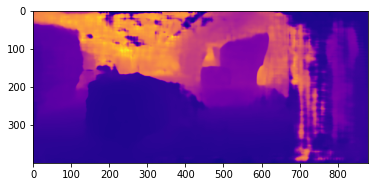

In [92]:
mask = disp_est > 0
depth = f_u * baseline / (disp_est + 1. - mask)
plt.imshow(depth, cmap="plasma")
plt.show()
im = Image.fromarray(depth).convert('RGB')

In [93]:
def project_image_to_rect(uv_depth):
    ''' Input: nx3 first two channels are uv, 3rd channel
               is depth in rect camera coord.
        Output: nx3 points in rect camera coord.
    '''
    n = uv_depth.shape[0]
    x = ((uv_depth[:, 0] - c_u) * uv_depth[:, 2]) / f_u + b_x
    y = ((uv_depth[:, 1] - c_v) * uv_depth[:, 2]) / f_v + b_y
    pts_3d_rect = np.zeros((n, 3))
    pts_3d_rect[:, 0] = x
    pts_3d_rect[:, 1] = y
    pts_3d_rect[:, 2] = uv_depth[:, 2]
    return pts_3d_rect

def project_image_to_velo(uv_depth):
    pts_3d_rect = project_image_to_rect(uv_depth)
    return pts_3d_rect

mask = disp_est > 0
rows, cols = depth.shape
c, r = np.meshgrid(np.arange(cols), np.arange(rows))
points = np.stack([c, r, depth])
points = points.reshape((3, -1))
points = points.T
points = points[mask.reshape(-1)]
cloud = project_image_to_velo(points)


points_rgb = depth_rgb.reshape((3, -1)).T
points_rgb = points_rgb.astype(float)
points_rgb /= 255.

In [94]:
cloud.shape

(352000, 3)

In [95]:
points_rgb.shape

(352000, 3)

In [96]:
# Pass xyz to Open3D.o3d.geometry.PointCloud and visualize
rgbd_pcd = o3d.geometry.PointCloud()
rgbd_pcd.points = o3d.utility.Vector3dVector(cloud)
rgbd_pcd.colors = o3d.utility.Vector3dVector(points_rgb)

o3d.visualization.draw_geometries([rgbd_pcd])

# Load VoxelNavNet

In [97]:
from models.Voxel2D import Voxel2D
voxel_model = Voxel2D(192, "voxel")
voxel_model = nn.DataParallel(voxel_model)
voxel_model.cuda()

DataParallel(
  (module): Voxel2D(
    (feature_extraction): feature_extraction(
      (firstconv): Sequential(
        (0): MobileV2_Residual(
          (conv): Sequential(
            (0): Conv2d(3, 9, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(9, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
            (3): Conv2d(9, 9, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=9, bias=False)
            (4): BatchNorm2d(9, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (5): ReLU6(inplace=True)
            (6): Conv2d(9, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
        )
        (1): ReLU(inplace=True)
        (2): MobileV2_Residual(
          (conv): Sequential(
            (0): Conv2d(32, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          

In [98]:
ckpt_path = "/home/chris/pl_ws/src/stereo_pl_nav/scripts/voxelstereonet/logs/lr_0.001_batch_size_16_cost_vol_type_voxel_optimizer_adam_/best.ckpt"
voxel_model.load_state_dict(torch.load(ckpt_path)['model'])

<All keys matched successfully>

In [99]:
# calculate voxel cost volume disparity set
vox_cost_vol_disp_set = set()
max_disp = 192
# depth starting from voxel_size since 0 will cause issue
for z in np.arange(0.5, 32, 0.5*3):
    # get respective disparity
    d = f_u * baseline / z

    if d > max_disp:
        continue

    # real disparity -> disparity in feature map
    vox_cost_vol_disp_set.add(round(d/4))

vox_cost_vol_disps = list(vox_cost_vol_disp_set)
vox_cost_vol_disps = sorted(vox_cost_vol_disps)

tmp = []
for i in vox_cost_vol_disps:
    tmp.append(torch.unsqueeze(torch.Tensor([i]), 0))
vox_cost_vol_disps = tmp

In [100]:
vox_cost_vol_disps

[tensor([[4.]]),
 tensor([[5.]]),
 tensor([[6.]]),
 tensor([[7.]]),
 tensor([[8.]]),
 tensor([[9.]]),
 tensor([[10.]]),
 tensor([[11.]]),
 tensor([[12.]]),
 tensor([[14.]]),
 tensor([[17.]]),
 tensor([[21.]]),
 tensor([[27.]]),
 tensor([[39.]])]

In [101]:
def get_model_pred(model, sample_left, sample_right, voxel_disp):
    with torch.no_grad():
        return model(sample_left.cuda(), sample_right.cuda(), voxel_disp)[0][0]

In [102]:
voxel_pred = get_model_pred(voxel_model, sample_left, sample_right, vox_cost_vol_disps)

In [103]:
def get_visualize(vox_pred, color=[1.0, 0.0, 0.0]):
    vox_pred = vox_pred.detach().cpu().numpy()
    vox_pred[vox_pred < 0.5] = 0
    vox_pred[vox_pred >= 0.5] = 1
    
    offsets = np.array([32, 62, 0])
    voxel_size = 0.5
    xyz_pred = np.asarray(np.where(vox_pred == 1)) # get back indexes of populated voxels
    cloud_pred = np.asarray([(pt-offsets)*voxel_size for pt in xyz_pred.T])
    
    pred_pcd = o3d.geometry.PointCloud()
    pred_pcd.points = o3d.utility.Vector3dVector(cloud_pred)
#     pred_pcd.paint_uniform_color(color)
    pred_pcd.colors = o3d.utility.Vector3dVector(np.random.uniform(0, 1, size=(len(cloud_pred), 3)))
    
    voxel_grid = o3d.geometry.VoxelGrid.create_from_point_cloud(pred_pcd,
                                                              voxel_size=0.5)    
    return voxel_grid

In [105]:
# Pass xyz to Open3D.o3d.geometry.PointCloud and visualize
rgbd_pcd = o3d.geometry.PointCloud()
rgbd_pcd.points = o3d.utility.Vector3dVector(cloud)
rgbd_pcd.colors = o3d.utility.Vector3dVector(points_rgb)

o3d.visualization.draw_geometries([rgbd_pcd, get_visualize(voxel_pred, color=[1.0, 0.0, 0.0])],
                                 front=[ 0.060748975810558881, 0.058005491788925577, -0.99646621862474261 ],
                                 lookat=[ -4.0462762398004077, -4.4849709120948287, 71.46948359545145 ],
                                 up=[ -0.0090143846276087292, -0.99823742766900436, -0.058658152635031047 ],
                                 zoom=0.3)

In [ ]:
unit_np_pcd = o3d.geometry.PointCloud()
unit_np_pcd.points = o3d.utility.Vector3dVector(np.array([[0.0, -2.0, 0.0],[0.0, 0.0, 0.0],[0.0, 4.0, 0.0]]))
unit_np_pcd.paint_uniform_color([0.0, 0.0, 1.0])
o3d.visualization.draw_geometries([rgbd_pcd, unit_np_pcd])